# Imports

In [1]:
from fastai import *
from fastai.collab import CollabDataBunch, CollabLearner

%matplotlib inline

# Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [2]:
path = Path('../data/ml-100k/')
path

PosixPath('../data/ml-100k')

In [3]:
path.ls()

[PosixPath('../data/ml-100k/u.item'),
 PosixPath('../data/ml-100k/u.info'),
 PosixPath('../data/ml-100k/u.genre'),
 PosixPath('../data/ml-100k/u.data'),
 PosixPath('../data/ml-100k/README'),
 PosixPath('../data/ml-100k/u.user'),
 PosixPath('../data/ml-100k/u.occupation')]

In [4]:
!head -10 ../data/ml-100k/u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


`collab` models use data in a `DataFrame` of user, items, and ratings.

In [5]:
user, item, title = 'userId', 'movieId', 'title'

In [6]:
ratings = pd.read_csv(path / 'u.data', delimiter='\t', header=None,
                      names=[user, item, 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
!head -10 ../data/ml-100k/u.item

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0
6|Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|01-Jan-1995||http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0
7|Twelve Monkeys (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|1|0|0|0
8|Babe (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Babe%20(1995)|0|0|0|0|1

In [8]:
movies = pd.read_csv(path / 'u.item',  delimiter='|', encoding='latin-1',
                     header=None, names=[item, 'title', 'date', 'N', 'url',
                                         *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


`CollabDataBunch` assumes the first column is user, the second is movie, and the third is rating.

In [10]:
data = CollabDataBunch.from_df(rating_movie, seed=42, pct_val=0.1, item_name=title)
len(data.train_ds), len(data.valid_ds)

(90000, 10000)

In [11]:
data.show_batch()

userId,title,target
504,Cape Fear (1991),4.0
407,"Sting, The (1973)",4.0
504,"Time to Kill, A (1996)",4.0
259,My Best Friend's Wedding (1997),4.0
638,Star Wars (1977),4.0
669,G.I. Jane (1997),1.0
456,Stand by Me (1986),3.0
507,Volcano (1997),5.0


# Model

In [12]:
class EmbeddingDotBias(nn.Module):
    '''
    Implement Collaborating Filtering model using only dot products of both
    users and items Embeddings plus bias.
    '''

    def __init__(self, n_users, n_items, embedding_size, y_range=None):
        super().__init__()
        if y_range and not isinstance(y_range, (tuple, list)):
            raise('y_range has to be tuple or list.')
        self.y_range = y_range
        self.users_weight = embedding(n_users, embedding_size)
        self.users_bias = embedding(n_users, 1)
        self.items_weight = embedding(n_items, embedding_size)
        self.items_bias = embedding(n_items, 1)
    
    def forward(self, users, items):
        dot_prod = self.users_weight(users) * self.items_weight(items)
        res = (dot_prod.sum(dim=1) + self.users_bias(users).squeeze()
               + self.items_bias(items).squeeze())
        if self.y_range:
            return (torch.sigmoid(res) * (self.y_range[1] - self.y_range[0])
                    + self.y_range[0])
        return res


def embedding(embedding_sz, embedding_dim):
    '''
    Create an Embedding and initialize it's weights to a truncated normal
    distribtion where weights that are 2xstd are truncated.
    '''
    embedding = nn.Embedding(embedding_sz, embedding_dim)
    with torch.no_grad():
        trunc_normal_(embedding.weight, std=0.01)
    return embedding


def trunc_normal_(x, mean=0, std=1):
    '''Initialize weights to a truncated normal distribution.'''
    return x.normal_().fmod_(2).mul_(std).add_(mean)



def collab_model(data, embedding_dim, y_range, wd=1e-2):
    users, items = data.classes.values()
    n_users, n_items = len(users), len(items)
    model = EmbeddingDotBias(n_users, n_items, embedding_dim, y_range)
    return CollabLearner(data, model, wd=wd)

In [13]:
y_range = [0, 5.5]
learn = collab_model(data, 40, y_range, wd=1e-1)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


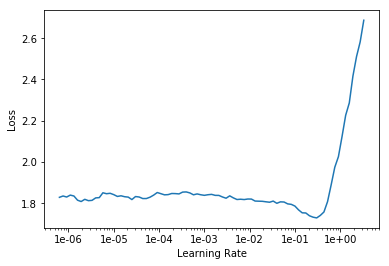

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(5, 5e-3)

Total time: 00:29
epoch  train_loss  valid_loss
1      0.911524    0.938959    (00:05)
2      0.835014    0.883468    (00:06)
3      0.760066    0.836351    (00:06)
4      0.645579    0.815061    (00:06)
5      0.545414    0.815201    (00:05)

